In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dataset/24-hours Delhi Power Consumption dataset.csv')

In [3]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [4]:
def assign_compensation_method(row):
    if row['is_holiday'] == 1:
        return 'Lower Power Supply'
    elif row['solar_generation'] > 200:
        return 'Increased Renewable Energy Integration'
    elif row['hour_of_day'] >= 18 and row['hour_of_day'] <= 22:
        return 'Peak Load Shifting'
    elif row['temperature'] > 35:
        return 'Increased Power Supply'
    else:
        return 'Normal Operation'

df['compensation_method'] = df.apply(assign_compensation_method, axis=1)

print(df[['timestamp', 'load', 'compensation_method']].head(10))


            timestamp   load                     compensation_method
0 2023-01-01 00:00:00  18493                        Normal Operation
1 2023-01-01 01:00:00  17090                        Normal Operation
2 2023-01-01 02:00:00  16052                        Normal Operation
3 2023-01-01 03:00:00  15356                        Normal Operation
4 2023-01-01 04:00:00  14936                        Normal Operation
5 2023-01-01 05:00:00  14884                        Normal Operation
6 2023-01-01 06:00:00  15314  Increased Renewable Energy Integration
7 2023-01-01 07:00:00  16591  Increased Renewable Energy Integration
8 2023-01-01 08:00:00  18271                        Normal Operation
9 2023-01-01 09:00:00  19470  Increased Renewable Energy Integration


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
X = df[['temperature', 'solar_generation', 'hour_of_day', 'load', 'is_holiday']]
y=df['compensation_method']
X_reg = df[['temperature', 'solar_generation', 'hour_of_day', 'is_holiday']]
y_reg = df['load']
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# from keras.optimizers import Adam
# from keras.layers import BatchNormalization
# from keras.layers import Activation
#ann

# Normalize the data
scaler_reg = StandardScaler()
scaler_cls = StandardScaler()

X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)
X_train_scaled = scaler_cls.fit_transform(X_train)
X_test_scaled = scaler_cls.transform(X_test)



In [9]:
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)


DecisionTreeClassifier()

In [10]:
# Define the parameter grid with corrected parameters
# import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],  # Keep only True since we're using max_samples
    'max_samples': [0.5, 0.75, 1.0],
    'oob_score': [True, False],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1  # Add verbosity to see progress
)

# Perform the grid search
grid_search.fit(X_reg_train_scaled, y_reg_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Mean Squared Error:", -grid_search.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}
Best Mean Squared Error: 4852906.883795895


In [11]:
rf_best = RandomForestRegressor(**grid_search.best_params_, random_state=42)
rf_best.fit(X_reg_train_scaled, y_reg_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.5,
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=200, oob_score=True, random_state=42)

In [12]:
# Decision Tree Classifier performance and Random Forest Regressor performance


from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

y_pred_dt = dt.predict(X_test_scaled)
class_accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Classification Model Accuracy: {class_accuracy_dt:.2f}")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

# Make predictions on the test set for regression (peak supply)
y_reg_pred_rf = rf_best.predict(X_reg_test_scaled)
reg_mse_rf = mean_squared_error(y_reg_test, y_reg_pred_rf)
reg_mae_rf = mean_absolute_error(y_reg_test, y_reg_pred_rf)
reg_r2_rf = r2_score(y_reg_test, y_reg_pred_rf)
reg_rmse_rf = root_mean_squared_error(y_reg_test, y_reg_pred_rf)
reg_mape_rf = mean_absolute_percentage_error(y_reg_test, y_reg_pred_rf)

y_mean = np.mean(y_reg_test)
CV_RMSE = (reg_rmse_rf / y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_rf:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_rf:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_rf:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_rf:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_rf * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")
print(confusion_matrix(y_test, y_pred_dt))

Classification Model Accuracy: 1.00
                                        precision    recall  f1-score   support

                Increased Power Supply       1.00      1.00      1.00       183
Increased Renewable Energy Integration       1.00      1.00      1.00       559
                    Lower Power Supply       1.00      1.00      1.00        22
                      Normal Operation       1.00      1.00      1.00      1373
                    Peak Load Shifting       1.00      1.00      1.00       485

                              accuracy                           1.00      2622
                             macro avg       1.00      1.00      1.00      2622
                          weighted avg       1.00      1.00      1.00      2622

Regression Model Mean Squared Error: 5257683.90
Regression Model Mean Absolute Error: 1687.10
Regression Model R^2 Score: 0.56
Regression Model Root Mean Squared Error: 2292.96
Regression Model Mean Absolute Percentage Error: 9.06%
Regressio

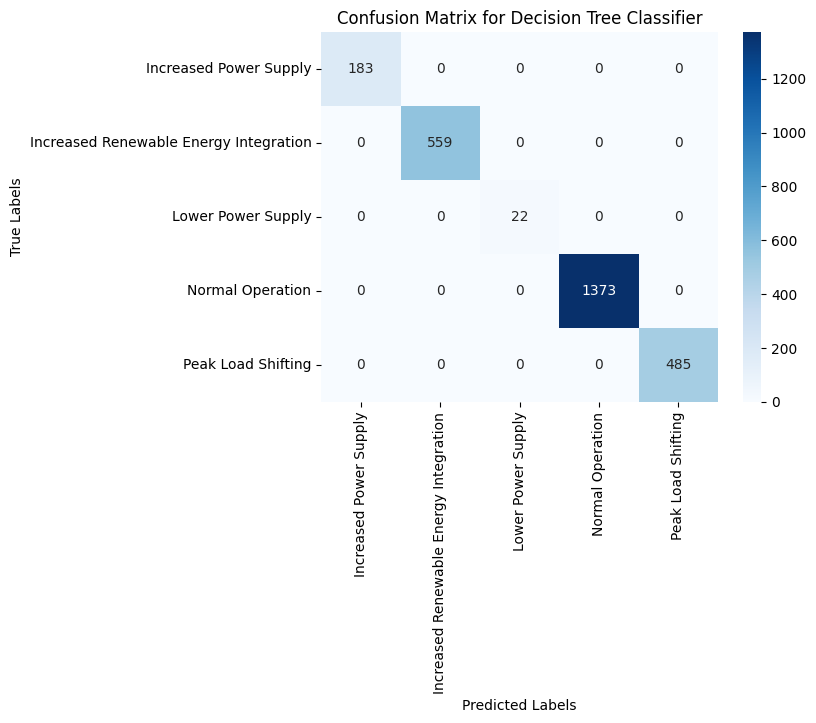

NameError: name 'classification_report_dict' is not defined

In [13]:
# Plot confusion matrix as a heatmap
confusion_matrix_data = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
# plt.xticks(rotation=30)
# plt.savefig("output/confusion_matrix_dt.svg")
plt.show()

# Plot classification report as a heatmap
sns.heatmap(pd.DataFrame(classification_report_dict).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title("Classification Report for Decision Tree Classifier")
plt.xlabel("Metrics")
plt.ylabel("Classes")
# plt.savefig("output/classification_report_dt.svg")
plt.show()

In [14]:
original=pd.read_csv('dataset/24-hours testset - Copy.csv')

In [19]:
def predict_for_date(date, temperature, solar_generation, hour_of_day, is_holiday, dt, rf, le, scaler_cls, scaler_reg):
    new_data_class = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'load': [0],
        'is_holiday': [is_holiday]
    })

    new_data_reg = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'is_holiday': [is_holiday]
    })
    
    # Scale the data
    new_data_class_scaled = scaler_cls.transform(new_data_class)
    new_data_reg_scaled = scaler_reg.transform(new_data_reg)
    
    # Decision Tree predictions
    dt_class_pred = dt.predict(new_data_class_scaled)
    
    # Random Forest predictions
    rf_reg_pred = rf.predict(new_data_reg_scaled)
    
    predicted_compensation_method = le.inverse_transform(dt_class_pred)
    predicted_peak_supply = rf_reg_pred

    return {
        'date': date,
        'hour_of_day': hour_of_day,
        'compensation_method': predicted_compensation_method[0],
        'peak_supply_needed': predicted_peak_supply[0]
    }

def generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, dt, rf, le, scaler_cls, scaler_reg):
    results = []
    hour = timestamp.hour
    prediction = predict_for_date(timestamp, temperature, solar_generation, hour, is_holiday, dt, rf, le, scaler_cls, scaler_reg)
    results.append(prediction)
    df_predictions = pd.DataFrame(results)
    return df_predictions

def generate_year_predictions(test_dataset, dt, rf, le, scaler_cls, scaler_reg):
    all_predictions = []
    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row['timestamp'])
        temperature = row['temperature']
        solar_generation = row['solar_generation']
        is_holiday = row['is_holiday']
        daily_predictions = generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, dt, rf, le, scaler_cls, scaler_reg)
        all_predictions.append(daily_predictions)
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)
    return df_all_predictions


In [20]:
# Generate predictions for the test dataset
df_predictions = generate_year_predictions(original, dt, rf_best, le, scaler_cls, scaler_reg)

C:\Users\ariel\AppData\Local\Temp\ipykernel_22380\299389985.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')


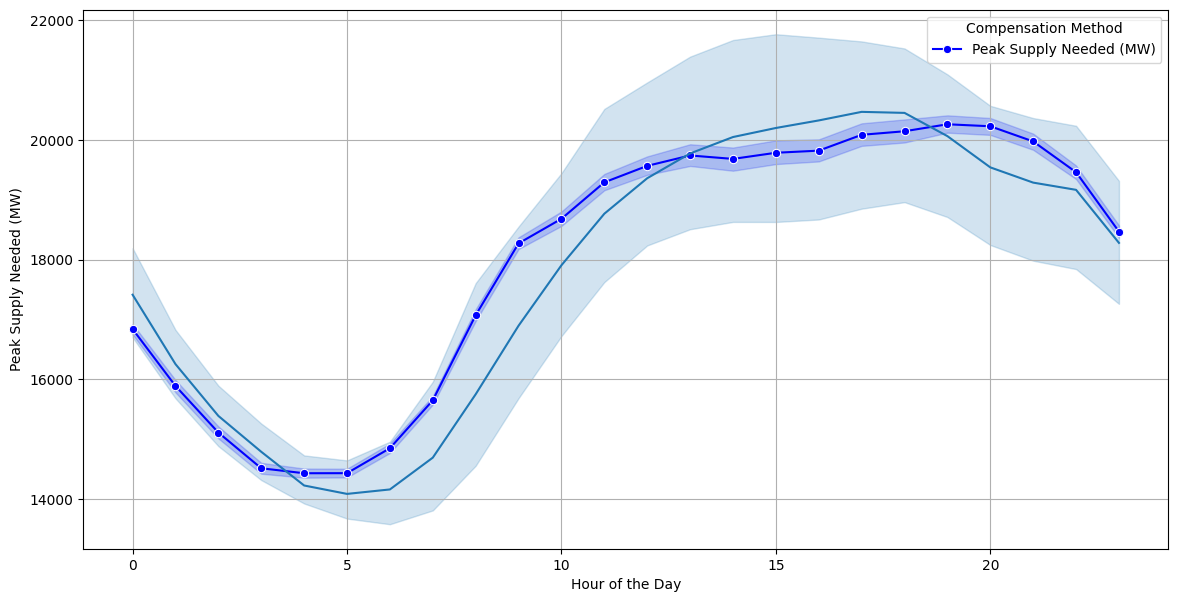

<Figure size 640x480 with 0 Axes>

In [21]:
def plot_predictions(df_predictions,name):
    plt.figure(figsize=(14, 7))

    sns.lineplot(data=df_predictions, x='hour_of_day', y='peak_supply_needed', marker='o', color='blue', label='Peak Supply Needed (MW)')
    
    sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')

    # plt.title('Hourly Predictions for {}'.format(df_predictions['date'][0]))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Peak Supply Needed (MW)')
    plt.legend(title='Compensation Method')
    plt.grid(True)
    plt.show()
    
    #save as svg
    plt.savefig(f'output/{name}.svg')

plot_predictions(df_predictions,'RF')